In [77]:
import datetime as dt
import pandas as pd
import numpy as np
import bs4
from urllib.request import urlopen
import re
import matplotlib.pyplot as plt
%matplotlib inline

## 한국 15대 기업 데이터 수집하기

In [2]:
url_float = 'http://companyinfo.stock.naver.com/company/c1010001.aspx?cmp_cd=005930'
url_float

'http://companyinfo.stock.naver.com/company/c1010001.aspx?cmp_cd=005930'

In [101]:
# 구성종목 기본정보 구하기

def stock_info(stock_cd):
    url_float = 'http://companyinfo.stock.naver.com/v1/company/c1010001.aspx?cmp_cd=' + stock_cd
    source = urlopen(url_float).read()
    soup = bs4.BeautifulSoup(source, 'lxml')
    
    tmp = soup.find(id = 'cTB11').find_all('tr')[6].td.text
    tmp = tmp.replace('\r','')
    tmp = tmp.replace('\t','')
    tmp = tmp.replace('\n','')
    tmp = re.split('/',tmp)
    
    outstanding = tmp[0].replace(',','')
    outstanding = outstanding.replace('주','')
    outstanding = outstanding.replace(' ','')
    outstanding = int(outstanding)
    
    floating = tmp[1].replace(' ','')
    floating = floating.replace('%','')
    floating = float(floating)
    
    name = soup.find(id='pArea').find('div').find('div').find('tr').find('td').find('span').text
    
    k15_outstanding[stock_cd] = outstanding
    k15_floating[stock_cd] = floating
    k15_name[stock_cd] = name


한국거래소 시가총액 상위 15 종목

- 005930 삼성전자
- 000660 SK하이닉스
- 005935 삼성전자우
- 051910 LG화학
- 005380 현대차
- 068270 셀트리온
- 207940 삼성바이오로직스
- 005490 POSCO
- 015760 한국전력
- 035420 NAVER
- 028260 삼성물산
- 012330 현대모비스
- 017670 SK텔레콤
- 055550 신한지주
- 051900 LG생활건강


In [92]:
k15_component = ['005930','000660','005935','051910','005380',
                    '068270','207940','005490','015760', '035420',
                    '028260','012330','017670','055550','051900']

In [93]:
k15_outstanding = dict()
k15_floating = dict()
k15_name = dict()

In [102]:
for stock_cd in k15_component:
    stock_info(stock_cd)

## 과거 주가 구하기

In [105]:
# 날짜 형식 바꾸는 함수
def date_format(d):
    d = str(d).replace('-','.')
    
    yyyy = int(d.split('.')[0])
    mm = int(d.split('.')[1])
    dd = int(d.split('.')[2])
    
    this_date = dt.date(yyyy,mm,dd)
    return(this_date)

In [106]:
# 일자별 주가 추출 함수 
def historical_stock(stock_cd, start_date='', end_date='', page_n=1, last_page=0):
    
    if start_date:
        start_date = date_format(start_date)
    else:
        start_date = dt.date.today()
    
    if end_date:
        end_date = date_format(end_date)
    else:
        end_date = dt.date.today()
        
    naver_stock = 'https://finance.naver.com/item/sise_day.nhn?code=' + stock_cd + \
                    '&page=' + str(page_n)
    
    source = urlopen(naver_stock).read()
    source = bs4.BeautifulSoup(source, 'lxml')
    
    dates = source.find_all('span',class_='tah p10 gray03') #날짜 수집
    prices = source.find_all('td',class_ = 'num') #종가 수집
    
    for n in range(len(dates)):
        
        if len(dates) > 0:
            
            #날짜 처리
            this_date = dates[n].text
            this_date = date_format(this_date)
            
            if this_date <= end_date and this_date >= start_date:
                #종가 처리
                this_close = prices[n*6].text
                this_close = this_close.replace(',','')
                this_close = float(this_close)
                
                #딕셔너리에 저장
                historical_prices[this_date] = this_close
            
            elif this_date < start_date:
                return historical_prices
    
    if last_page == 0:
        last_page = source.find_all('table')[1].find('td', class_='pgRR').find('a')['href']
        last_page = last_page.split('&')[1]
        last_page = last_page.split('=')[1]
        last_page = float(last_page)
        
    #다음 페이지 호출
    if page_n < last_page:
        page_n += 1
        historical_stock(stock_cd, start_date, end_date, page_n, last_page)
        
    return historical_prices            

#### 과거 시세 받아오기

In [111]:
k15_historical_prices = dict()

for stock_cd in k15_component:
    historical_prices = dict()
    start_date = '2017-1-1'
    end_date = '2017-12-31'
    historical_stock_naver(stock_cd, start_date, end_date)
    
    k10_historical_prices[stock_cd] = historical_prices

In [112]:
k15_historical_price = pd.DataFrame(k10_historical_prices)

**Missing value 채우기**

In [113]:
k15_historical_price = k15_historical_price.fillna(method='ffill')

if k15_historical_price.isnull().values.any():
    k15_historical_price = k15_historical_price.fillna(method='bfill')
k15_historical_price.head(3)

,005930,000660,005935,051910,005380,068270,207940,005490,015760,035420,028260,012330,017670,055550,051900
2017-01-02,1805000.0,45800.0,1440000.0,253000.0,150000.0,108200.0,156500.0,260500.0,43900.0,777000.0,125500.0,271500.0,225500.0,45300.0,817000.0
2017-01-03,1824000.0,47250.0,1439000.0,262000.0,153000.0,106600.0,158000.0,256000.0,44100.0,767000.0,129000.0,275500.0,223000.0,46450.0,836000.0
2017-01-04,1808000.0,46500.0,1440000.0,268500.0,154000.0,106100.0,154500.0,254500.0,43900.0,810000.0,129000.0,276000.0,223000.0,47000.0,851000.0


삼성전자가 2018년 5월 4일부로 1/50 액면분할을 실시해 그날부터 주가는 이전의 1/50으로 감소하고, 동시에 주식 수는 50배로 증가했다. 따라서 전체 시가총액에는 영향이 없으나, 우리가 사용한 데이터에서 주식 수는 50배 증가된 현재 데이터를 사용하지만, 주가는 1/50 감소 이전의 과거 데이터를 사용하는 것이된다. 따라서 과거 주가를 50으로 나눠 수정주가를 구한 후, 이를 이용해 시가총액을 계산해야 한다. 

In [114]:
k15_historical_price['005930'] = k15_historical_price['005930'] / 50
k15_historical_price['005935'] = k15_historical_price['005935'] / 50

k15_historical_price.head(3)

,005930,000660,005935,051910,005380,068270,207940,005490,015760,035420,028260,012330,017670,055550,051900
2017-01-02,36100.0,45800.0,28800.0,253000.0,150000.0,108200.0,156500.0,260500.0,43900.0,777000.0,125500.0,271500.0,225500.0,45300.0,817000.0
2017-01-03,36480.0,47250.0,28780.0,262000.0,153000.0,106600.0,158000.0,256000.0,44100.0,767000.0,129000.0,275500.0,223000.0,46450.0,836000.0
2017-01-04,36160.0,46500.0,28800.0,268500.0,154000.0,106100.0,154500.0,254500.0,43900.0,810000.0,129000.0,276000.0,223000.0,47000.0,851000.0


## K15 지수 산출

* 지수 = (비교 시점 시가총액) / (기준 시점 시가총액) * 100
* 시가총액 = 주가 * 상장주식 수 
* 유동비율 반영 시가총액 = 주가 * 상장주식 수 * 유동비율

In [115]:
tmp = {'Outstanding': k15_outstanding,
      'Floating': k15_floating,
      'Price': k15_historical_price.iloc[0],
      'Name': k15_name}
k15_info = pd.DataFrame(tmp)

In [117]:
k15_info.tail(3)

,Outstanding,Floating,Price,Name
055550,474199587,85.14,45300.0,신한지주
068270,127953489,66.22,108200.0,셀트리온
207940,66165000,24.75,156500.0,삼성바이오로직스


In [118]:
k15_info['Market_Cap'] = k15_info['Outstanding'] * k15_info['Price'] * 0.01
k15_info['f_Market_Cap'] = k15_info['Outstanding'] * k15_info['Floating'] * \
                            k15_info['Price'] * 0.01
k15_info.head(3)

,Outstanding,Floating,Price,Name,Market_Cap,f_Market_Cap
000660,728002365,73.89,45800.0,SK하이닉스,3.334251e+11,2.463678e+13
005380,213668187,65.77,150000.0,현대차,3.205023e+11,2.107943e+13
005490,87186835,79.60,260500.0,POSCO,2.271217e+11,1.807889e+13


**날짜별 시가총액 구하기**

In [119]:
k15_historical_mc = k15_historical_price * k15_info['Outstanding'] * k15_info['Floating'] * 0.01
k15_historical_mc.head(3)

,000660,005380,005490,005930,005935,012330,015760,017670,028260,035420,051900,051910,055550,068270,207940
2017-01-02,2.463678e+13,2.107943e+13,1.807889e+13,1.697781e+14,1.354462e+14,1.773905e+13,1.376983e+13,1.133094e+13,1.239822e+13,1.008729e+14,7.634348e+12,1.148032e+13,1.828913e+13,9.167873e+12,2.562819e+12
2017-01-03,2.541676e+13,2.150102e+13,1.776658e+13,1.715652e+14,1.353522e+14,1.800040e+13,1.383257e+13,1.120532e+13,1.274398e+13,9.957463e+13,7.811891e+12,1.188871e+13,1.875342e+13,9.032303e+12,2.587382e+12
2017-01-04,2.501332e+13,2.164155e+13,1.766248e+13,1.700603e+14,1.354462e+14,1.803307e+13,1.376983e+13,1.120532e+13,1.274398e+13,1.051570e+14,7.952057e+12,1.218366e+13,1.897548e+13,8.989938e+12,2.530067e+12


In [120]:
k15 = pd.DataFrame()
k15['K15_Market_Cap'] = k15_historical_mc.sum(axis=1)
k15.head(3)

,K15_Market_Cap
2017-01-02,5.742649e+14
2017-01-03,5.770324e+14
2017-01-04,5.813643e+14


마지막 과정으로 2017년 1월 2일 시가총액을 기준으로 K10 지수를 산출하자. 

In [121]:
k15['K15'] = k15['K15_Market_Cap'] / k15['K15_Market_Cap'][0] * 100
k15.head(3)

,K15_Market_Cap,K15
2017-01-02,5.742649e+14,100.000000
2017-01-03,5.770324e+14,100.481932
2017-01-04,5.813643e+14,101.236274


## 지수 그래프 그리기

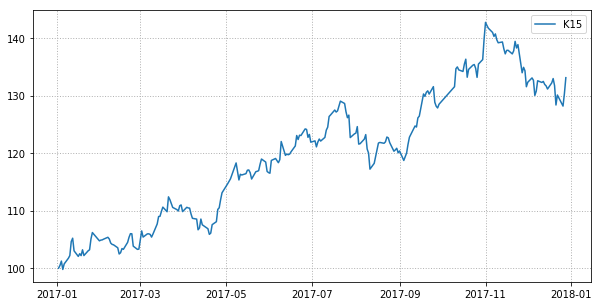

In [122]:
plt.figure(figsize = (10,5))
plt.plot(k15['K15'])
plt.legend(loc=0)
plt.grid(True, color = '0.7', linestyle = ':', linewidth=1)

## K15 지수를 이용한 K15 인덱스 펀드

이 펀드는 K15 종목을 포트폴리오로 편입하고 벤치마크는 KOSPI200이다. 한국거래소의 상위 15개 종목만 이용해서 KOSPI200 인덱스의 수익률을 따라가려는 펀드이다.

### < K15 펀드 투자설명서 >

**투자 목표**: 펀드의 순자산가치 변동률을 KOSPI200 지수의 변동률과 유사하도록 운용한다.


**투자 전략**: 투자 목표를 추구하며 동시에 금융공학 학습의 용이성을 확보하기 위해 KOSPI200 종목에서 시가총액 기준으로 상위 15개 종목을 선정해 투자한다. 이로써 지수 수익률을 확보하며 가끔 발생하는 추적오차 현상을 관찰하고 원인을 파악하자.


**포트폴리오 구성**: KOSPI200 상위 15개 종목으로 구성된 K15 지수를 산출하고, 펀드 자산 전체를 K15 지수 구성대로 주식을 매입하여 운용한다.


**포트폴리오 조정**: 2017년 1월 2일 ~ 2017년 12월 28일까지 1년간만 운용하는 펀드로 별도의 리밸런싱은 없다.

* 이 펀드는 15개 종목만으로 KOSPI200지수를 따라가야 하기 때문에 추적오차가 많이 발생할 것으로 예상한다.
* 최초 설정은 100만 좌로 시작하고 운용 기간 중 50만 좌 이하로 내려가지 않는다 가정하자

In [125]:
# K15 구성종목 확인
k15_info

,Outstanding,Floating,Price,Name,Market_Cap,f_Market_Cap
000660,728002365,73.89,45800.0,SK하이닉스,3.334251e+11,2.463678e+13
005380,213668187,65.77,150000.0,현대차,3.205023e+11,2.107943e+13
005490,87186835,79.60,260500.0,POSCO,2.271217e+11,1.807889e+13
005930,5969782550,78.78,36100.0,삼성전자,2.155092e+12,1.697781e+14
005935,5969782550,78.78,28800.0,삼성전자,1.719297e+12,1.354462e+14
012330,97343863,67.12,271500.0,현대모비스,2.642886e+11,1.773905e+13
015760,641964077,48.86,43900.0,한국전력,2.818222e+11,1.376983e+13
017670,80745711,62.23,225500.0,SK텔레콤,1.820816e+11,1.133094e+13
028260,189690043,52.08,125500.0,삼성물산,2.380610e+11,1.239822e+13
035420,164813395,78.77,777000.0,NAVER,1.280600e+12,1.008729e+14


In [126]:
# K15 지수 확인
k15.head()

,K15_Market_Cap,K15
2017-01-02,5.742649e+14,100.000000
2017-01-03,5.770324e+14,100.481932
2017-01-04,5.813643e+14,101.236274
2017-01-05,5.730132e+14,99.782040
2017-01-06,5.785487e+14,100.745965


**K15 지수와 KOSPI200 지수 비교하기**

In [127]:
# 그래프에서 한글 사용 세팅
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

In [128]:
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['lines.antialiased'] = True

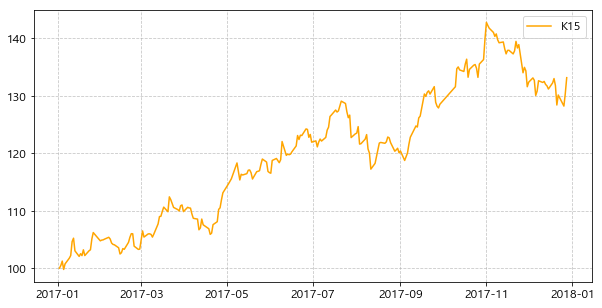

In [133]:
plt.plot(k15['K15'], color = 'orange', label = 'K15')
plt.legend(loc=0)
plt.grid(True)

**KOSPI200 가져오기**

In [135]:
# 날짜별 인텍스 추출하는 함수 만들기
def historical_index(index_cd, start_date='', end_date='', page_n=1, last_page=0):
    
    if start_date:   # start_date가 있으면
        start_date = date_format(start_date)   # date 포맷으로 변환
    else:    # 없으면
        start_date = dt.date.today()   # 오늘 날짜를 지정
    if end_date:   
        end_date = date_format(end_date)   
    else:   
        end_date = dt.date.today()  
        
        
    naver_index = 'http://finance.naver.com/sise/sise_index_day.nhn?code=' + index_cd + '&page=' + str(page_n)
    
    source = urlopen(naver_index).read()   # 지정한 페이지에서 코드 읽기
    source = bs4.BeautifulSoup(source, 'lxml')   # 뷰티풀 스프로 태그별로 코드 분류
    
    dates = source.find_all('td', class_='date')   # <td class="date">태그에서 날짜 수집   
    prices = source.find_all('td', class_='number_1')   # <td class="number_1">태그에서 지수 수집
    
    for n in range(len(dates)):
    
        if dates[n].text.split('.')[0].isdigit():
            
            # 날짜 처리
            this_date = dates[n].text
            this_date= date_format(this_date)
            
            if this_date <= end_date and this_date >= start_date:   
            # start_date와 end_date 사이에서 데이터 저장
                # 종가 처리
                this_close = prices[n*4].text   # prices 중 종가지수인 0,4,8,...번째 데이터 추출
                this_close = this_close.replace(',', '')
                this_close = float(this_close)

                # 딕셔너리에 저장
                historical_prices[this_date] = this_close
                
            elif this_date < start_date:   
            # start_date 이전이면 함수 종료
                return historical_prices              
            
    # 페이지 네비게이션
    if last_page == 0:
        last_page = source.find('td', class_='pgRR').find('a')['href']
        # 마지막페이지 주소 추출
        last_page = last_page.split('&')[1]   # & 뒤의 page=506 부분 추출
        last_page = last_page.split('=')[1]   # = 뒤의 페이지번호만 추출
        last_page = int(last_page)   # 숫자형 변수로 변환
        
    # 다음 페이지 호출
    if page_n < last_page:   
        page_n = page_n + 1   
        historical_index_naver(index_cd, start_date, end_date, page_n, last_page)   
        
    return historical_prices

In [136]:
index_cd = 'KPI200'
historical_prices = dict()
kospi200 = historical_index(index_cd, '2017-1-1', '2017-12-31')
k200 = pd.DataFrame({'Index' : kospi200})
k200.head(3)

,Index
2017-01-02,260.36
2017-01-03,262.97
2017-01-04,263.12


In [138]:
# 편하게 비교하기 위해 K15 지수를 KOSPI200 과 맞추기 (기준일 기준으로)
base_date = dt.date(2017,1,2)
k15['Adj Index'] = k15['K15_Market_Cap'] / k15['K15_Market_Cap'][base_date] * \
                    k200['Index'][base_date]
k15.head(3)

,K15_Market_Cap,K15,Adj Index
2017-01-02,5.742649e+14,100.000000,260.360000
2017-01-03,5.770324e+14,100.481932,261.614757
2017-01-04,5.813643e+14,101.236274,263.578763


**K15 지수와 KOSPI200 지수 비교하기**

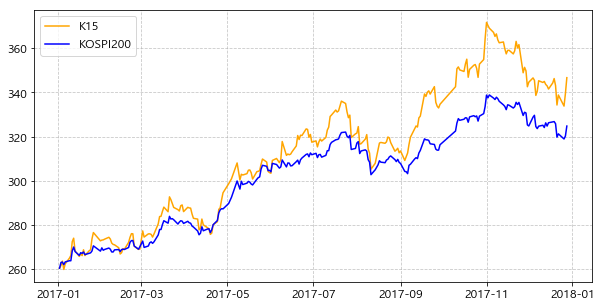

In [139]:
plt.plot(k15['Adj Index'], color = 'orange', label='K15')
plt.plot(k200['Index'], color = 'blue', label = 'KOSPI200')
plt.legend(loc=0)
plt.grid(True)

- KOSPI200 보다 K15가 수익률이 더 높은 것을 확인 할 수 있다.

## K15 펀드 설계 및 운용

본격적으로 K15 펀드를 만들어보자.

**펀드 기본정보 세팅하기**

In [141]:
CU = 500000 #설정 및 환매 단위 (creation unit: the minimum # of shares of ETF)
base_date = dt.date(2017,1,2)
volume = 1000000 # 최초 설정 수량
interest_rate = 0.02 

펀드 운용 기간 중 매일매일 설정과 환매가 발생할 수 있다. 설정과 환매가 얼마나 많을지는 예측불가하므로 random함수를 이용한다. 환매의 경우 최소 50만 좌 이상은 유지하기 위하여 50만 좌 이상인 경우에만 환매가 일어나도록 조건을 추가한다.

In [142]:
def creation_redemption(v):
    
    creation = np.random.randint(0,5) * CU
    
    if v > 500000:
        redemption = np.random.randint(0, 5) * CU
    else:
        redemption = 0
        
    volume = v + creation - redemption
    
    return(creation, redemption, volume)

매일 주가가 변동함에 따라 보유해야 할 주식의 비중이 달라진다. 따라서 날짜별 보유 비중을 구하자.

In [146]:
# 날짜별 시가총액
k15_historical_mc.head(3)

,000660,005380,005490,005930,005935,012330,015760,017670,028260,035420,051900,051910,055550,068270,207940
2017-01-02,2.463678e+13,2.107943e+13,1.807889e+13,1.697781e+14,1.354462e+14,1.773905e+13,1.376983e+13,1.133094e+13,1.239822e+13,1.008729e+14,7.634348e+12,1.148032e+13,1.828913e+13,9.167873e+12,2.562819e+12
2017-01-03,2.541676e+13,2.150102e+13,1.776658e+13,1.715652e+14,1.353522e+14,1.800040e+13,1.383257e+13,1.120532e+13,1.274398e+13,9.957463e+13,7.811891e+12,1.188871e+13,1.875342e+13,9.032303e+12,2.587382e+12
2017-01-04,2.501332e+13,2.164155e+13,1.766248e+13,1.700603e+14,1.354462e+14,1.803307e+13,1.376983e+13,1.120532e+13,1.274398e+13,1.051570e+14,7.952057e+12,1.218366e+13,1.897548e+13,8.989938e+12,2.530067e+12


In [147]:
#보유 비중 산정
k15_stock_ratio = pd.DataFrame()

for s in k15_info.index:
    k15_stock_ratio[s] = k15_historical_mc[s] / k15_historical_mc.sum(axis=1)
    
k15_stock_ratio.head(3)

,000660,005380,005490,005930,005935,012330,015760,017670,028260,035420,051900,051910,055550,068270,207940
2017-01-02,0.042901,0.036707,0.031482,0.295644,0.235860,0.030890,0.023978,0.019731,0.021590,0.175656,0.013294,0.019991,0.031848,0.015965,0.004463
2017-01-03,0.044047,0.037261,0.030790,0.297323,0.234566,0.031195,0.023972,0.019419,0.022085,0.172563,0.013538,0.020603,0.032500,0.015653,0.004484
2017-01-04,0.043025,0.037225,0.030381,0.292519,0.232980,0.031019,0.023685,0.019274,0.021921,0.180880,0.013678,0.020957,0.032640,0.015464,0.004352


이제 날짜별 보유 비중 변동과 설정 및 환매 수량 변동에 따라 펀드의 포트폴리오가 어떻게 변하고, 그 결과 펀드의 자산가치가 변하는 과정을 보자.

In [175]:
Fund_NAV = pd.DataFrame()  # 펀드의 순자산가치
Fund_Chg = pd.DataFrame()  # 펀드의 순자산가치 변화

In [176]:
for d in k15_historical_price.index:
    #포트폴리오 구성용 정보 (당일 주가, 자산 비중)
    stock_price = np.array(k15_historical_price.loc[d])
    stock_weight = np.array(k15_stock_ratio.loc[d])
    
    #전일까지의 주식 포트폴리오의 NAV 계산
    if (d <= base_date): #기준일 이전
        
        # 최초 주식 포트폴리오(보유량 0)
        stock_holdings = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
        NAV_cash = 0 # 최초 현금 보유량
        
    else:   #기준일 이후
        NAV_stock = sum(stock_holdings * stock_price)   # 전체 주식 잔고 계산
        NAV = NAV_stock + NAV_cash    # 전체 잔고
        
        
    #기준가격 산정
    if (d <= base_date):
        #최초 기준가를 기준일자의 KOSPI200 지수와 맞춤
        price = k200['Index'][base_date] * 100
    else:
        price = NAV / volume
        
    #신규 펀드 설정 및 환매 좌수 계산
    if (d == base_date):
        volume = 0  # 펀드 좌수
        volume_chg = 1000000  # 첫날 설정액
    else:
        vol = creation_redemption(volume)
        volume_chg = vol[0] - vol[1]  # 변동 좌수 계산
    
    #총 펀드 좌수에 반영
    volume = volume + volume_chg
    
    #펀드에 입출금된 자산의 총액 계산
    aum_chg = price * volume_chg
    
    
    #신규 주식 거래량 계산
    stock_trade = np.floor(price * volume_chg * stock_weight / stock_price)
    
    #당일 주식 매매 금액 총액
    trade_amt = sum(stock_trade * stock_price)
    
    #현금 잔고 변동
    cash_chg = aum_chg - trade_amt
    
    #총 주식 보유량 = 기존 보유량 + 신규 거래량
    stock_holdings = stock_holdings + stock_trade
    
    #현금 보유량 증가 (이자율 반영)
    cash_holdings = np.floor( NAV_cash * np.exp(interest_rate/365))
    
    # NAV 업데이트
    NAV_stock = sum(stock_holdings * stock_price) #주식 잔고
    NAV_cash = cash_holdings + cash_chg # 현금 잔고
    NAV = NAV_stock + NAV_cash # 전체 잔고
    
    date = pd.Series(d)
    
    # Fund NAV정보를 저장
    NAV_tmp = {'Stock': NAV_stock, 'Cash': NAV_cash, 'Total': NAV,
              'Price': price}
    tmp = pd.DataFrame(NAV_tmp, index = date)
    Fund_NAV = Fund_NAV.append(tmp)
    
    #날짜별 설정 및 환매 좌수 정보 저장
    Chg_tmp = {'Amount Change': aum_chg, 'Trade Amount': trade_amt,
              'Cash Change': cash_chg}
    tmp = pd.DataFrame(Chg_tmp, index = date)
    Fund_Chg = Fund_Chg.append(tmp)

이제 K15 펀드의 수익률을 확인해보자.

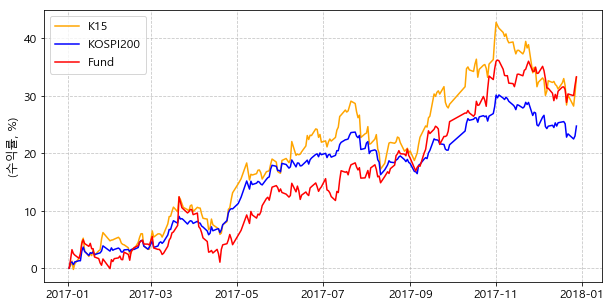

In [178]:
# 펀드 수익률 vs 지수 수익률
Earnings = pd.DataFrame()
Earnings['K15'] = (k15['K15'] - k15['K15'][base_date]) / k15['K15'][base_date] * 100
Earnings['KOSPI200'] = (k200['Index'] - k200['Index'][base_date]) / k200['Index'][base_date] * 100
Earnings['Fund'] = (Fund_NAV['Price'] - Fund_NAV['Price'][base_date]) / Fund_NAV['Price'][base_date] * 100

ax = Earnings.plot(color = ['orange','blue','red'])
ax.legend(loc=0)
ax.set_ylabel('(수익률, %)')
ax.grid(True)

K15 펀드의 수익률과 K15 지수의 수익률이 차이를 보이고, KOSPI200의 수익률보다 낮은 움직임을 보였다.

**수익률과 펀드의 NAV 변동**

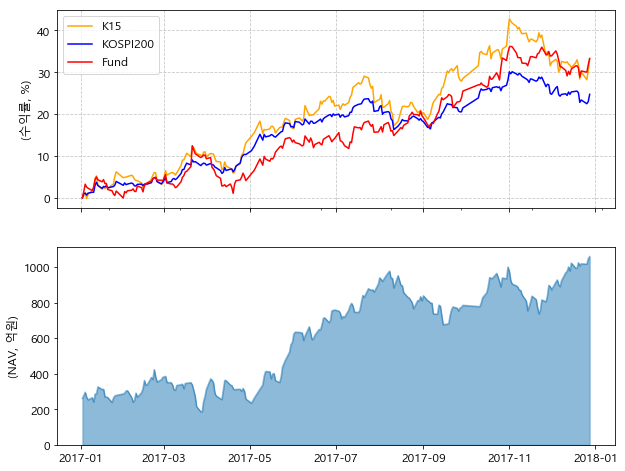

In [179]:
fig = plt.figure(figsize = (10,8))
ax1= fig.add_subplot(2,1,1)
ax2= fig.add_subplot(2,1,2)
Earnings.plot.line(ax=ax1, color = ['orange', 'b','r'])
ax1.set_ylabel('(수익률, %)')
Fund_NAV['Display'] = Fund_NAV['Total'] * 0.00000001
Fund_NAV['Display'].plot.area(ax = ax2, stacked = False, sharex = True)
ax2.set_ylabel('(NAV, 억원)')
ax1.grid(True)

**일간 수익률 그래프**

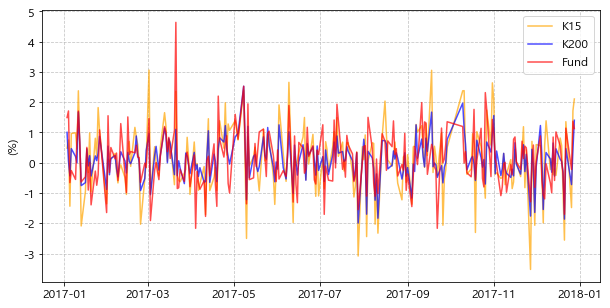

In [180]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

Daily = pd.DataFrame()
Daily['K15'] = (k15['K15'] - k15['K15'].shift(1)) / k15['K15'].shift(1) * 100
Daily['K200'] = (k200['Index'] - k200['Index'].shift(1)) / k200['Index'].shift(1) * 100
Daily['Fund'] = (Fund_NAV['Price'] - Fund_NAV['Price'].shift(1)) / Fund_NAV['Price'].shift(1) * 100

Daily.plot(ax=ax, color = ['orange','blue','red'], alpha = 0.7)
ax.set_ylabel('(%)')
ax.grid(True)

펀드의 일간 수익률이 KOSPI200의 일간 수익률보다 더 큰 폭으로 움직인다. 

**추적오차 구하기**

* 추적오차 = 펀드 수익률 - 지수 수익률

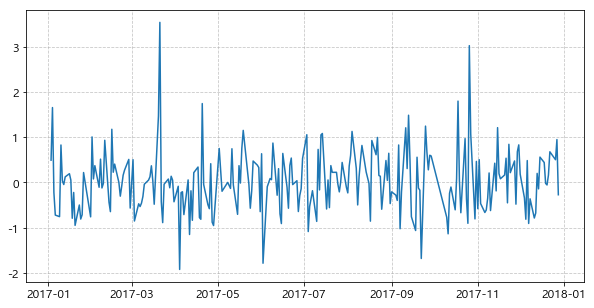

In [182]:
# KOSPI200 대비 일간 추적오차율

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
Daily['TE200'] = Daily['Fund'] - Daily['K200']     #추적오차율
Daily['TE200'].plot(ax=ax)
ax.grid(True)

대부분의 오차가 += 1 이내, 최대 +-3.4 정도 벌어지는 것을 확인할 수 있다. 15개 종목만으로 200개 종목을 따라가기에 추저오차가 약간 벌어지는 것을 볼 수 있다. 그러면 K15 지수와의 추적오차율은 어떻게 될까?

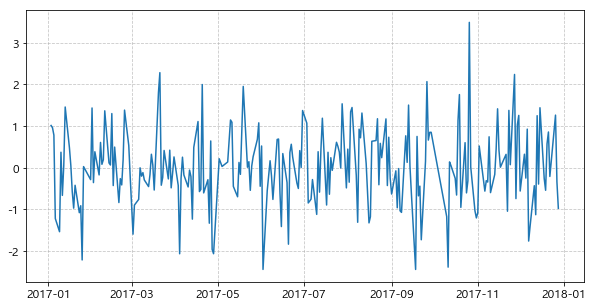

In [183]:
# K15 대비 일간 추적오차율
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
Daily['TE15'] = Daily['Fund'] - Daily['K15']
Daily['TE15'].plot(ax = ax)
ax.grid(True)

K15와의 추적오차는 KOSPI200와의 오차보다 약간 크다. 그렇다면 KOSPI200 지수를 추적하기 위해 200개 종목을 다 담는 KODEX200, TIGER200과 같은 펀드는 추적오차가 거의 발생하지 않는 아주 좋은 펀드일 것으로 추정된다.

또한 KOSPI200과의 추적오차가 큰 것으로 보아 15개 종목만으로 KOSPI200 펀드 운용은 약간 무리일것이라 판단된다. 